**The core notebooks for this project are:**

*   01_eda_data_cleaning.ipynb
*   02_baseline_models.ipynb
*   03_transformers.ipynb
*  streamlit_prototype.ipynb


**Notebook 01 - EDA & Data Preparation**

This notebook performs exploratory data analysis and text preprocessing on the GoEmotions dataset. It prepares cleaned text, encoded labels, and feature representations for both baseline and transformer models, and defines shared utility functions used across subsequent notebooks.

In [1]:
#project paths:
#project root: /content/drive/MyDrive/applied_research_project/
#cleaned data directory: /content/drive/MyDrive/applied_research_project/data
#prototype directory: /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype
#best model storage path: /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype/best_emo_model

In [2]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Import Libraries

In [3]:
#main python and data handling libraries
import numpy as np
import pandas as pd
import os, random, re, html, unicodedata
from html import unescape
from collections import Counter

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning & evaluation metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score

import joblib

# 2.Load the GoEmotion Train, Test, and Val Splits from official Google Research Repository

In [4]:
#load the GoEmotions train split from the official Google Research Repository
train_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/train.tsv'
train_df=pd.read_csv(train_url,sep='\t',header=None)
print(f"Shape of train split: ",train_df.shape)
train_df.head()

Shape of train split:  (43410, 3)


,0,1,2
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [5]:
#change the colum names of the train split
train_df.columns = ["text", "emotion_id", "comment_id"]
train_df.head()

,text,emotion_id,comment_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [6]:
#load the GoEmotions test split from the official Google Research Repository
test_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/test.tsv'
test_df=pd.read_csv(test_url,sep='\t', header=None)
print(f"Shape of test split: ",test_df.shape)
test_df.head()

Shape of test split:  (5427, 3)


,0,1,2
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [7]:
#change the colum names of the test split
test_df.columns = ["text", "emotion_id", "comment_id"]
test_df.head()

,text,emotion_id,comment_id
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [8]:
#load the GoEmotions val split from the official Google Research Repository
val_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/dev.tsv'
val_df=pd.read_csv(val_url, sep='\t', header=None)
print(f"Shape of val split: ",val_df.shape)
val_df.head()

Shape of val split:  (5426, 3)


,0,1,2
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [9]:
#change the colum names of the val split
val_df.columns = ["text", "emotion_id", "comment_id"]
val_df.head()

,text,emotion_id,comment_id
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [10]:
#load the GoEmotions emotion list from the official Google Research Repository
emotions_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/emotions.txt'
emotions=pd.read_csv(emotions_url,header=None)

print(f"Total num of emotions: ", len(emotions), '\n')
for emo in emotions[0]:
  print(emo)


Total num of emotions:  28 

admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral


# 3.EDA

This section explores the GoEmotions dataset to examine label distributions, class imbalance, co-occurrence patterns, and basic text characteristics relevant to multi-label emotion modelling.

In [11]:
#print the shape of train, test and val splits
print(f"Train dataset shape:",train_df.shape)
print(f"Test dataset shape:", test_df.shape)
print(f"Validation dataset shape:", val_df.shape)

Train dataset shape: (43410, 3)
Test dataset shape: (5427, 3)
Validation dataset shape: (5426, 3)


In [12]:
#print dataset structure and non-null counts for each split
print(f"Train Split:\n")
train_df.info()

print(f"\nTest Split:\n")
test_df.info()

print(f"\nVal Split:\n")
val_df.info()

Train Split:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        43410 non-null  object
 1   emotion_id  43410 non-null  object
 2   comment_id  43410 non-null  object
dtypes: object(3)
memory usage: 1017.6+ KB

Test Split:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5427 entries, 0 to 5426
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        5427 non-null   object
 1   emotion_id  5427 non-null   object
 2   comment_id  5427 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB

Val Split:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        5426 non-null   object
 1   emotion_id  5426 non-null   o

In [13]:
#combine train, test, and val splits into one dataframe
df_all = pd.concat([train_df, test_df, val_df], ignore_index=True)

#add emotion_label column in alignment with emotion id
df_all["emotion_label"] = df_all["emotion_id"].apply(
  lambda x: [emotions.iloc[int(i), 0] for i in str(x).split(',')]
)

In [14]:
#count num of texts with single/multiple emotions

single_label_texts = df_all[df_all['emotion_label'].map(len) == 1].shape[0]
multi_label_texts = df_all[df_all['emotion_label'].map(len) > 1].shape[0]
print(f"Num of texts with a single emotion label:",single_label_texts,"\nNum of texts with multiple emotion labels:", multi_label_texts)

Num of texts with a single emotion label: 45446 
Num of texts with multiple emotion labels: 8817


emotion_label
0        0
1    45446
2     8124
3      655
4       37
5        1
Name: count, dtype: int64


Text(0, 0.5, 'Count')

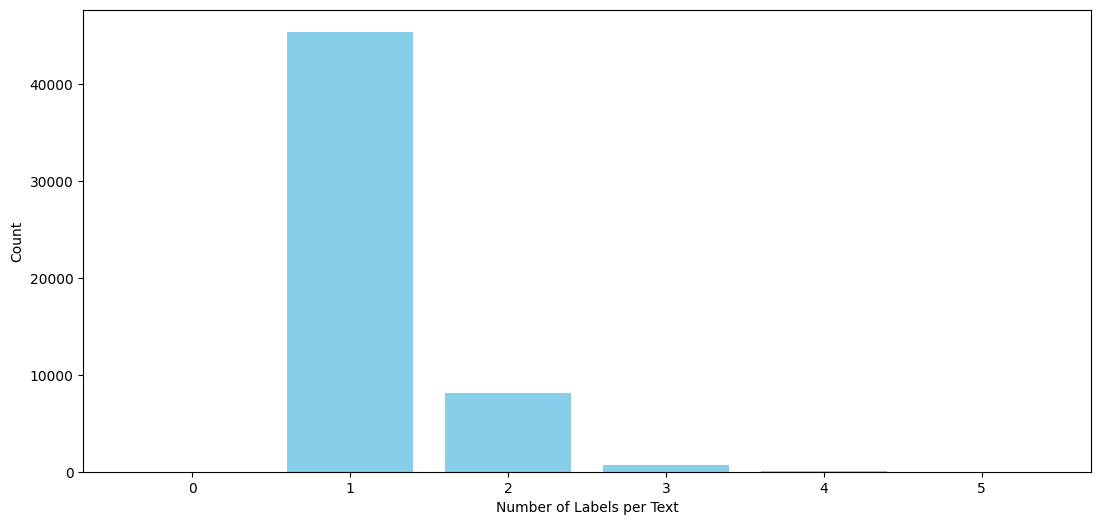

In [15]:
#count the num of labels per text for all rows
labels_per_text=df_all["emotion_label"].apply(len).value_counts()
labels_per_text=labels_per_text.reindex(range(0, labels_per_text.index.max() + 1), fill_value=0)
print(labels_per_text)

plt.figure(figsize=(13,6))
plt.bar(labels_per_text.index, labels_per_text.values, color='skyblue')
plt.xlabel("Number of Labels per Text")
plt.ylabel("Count")

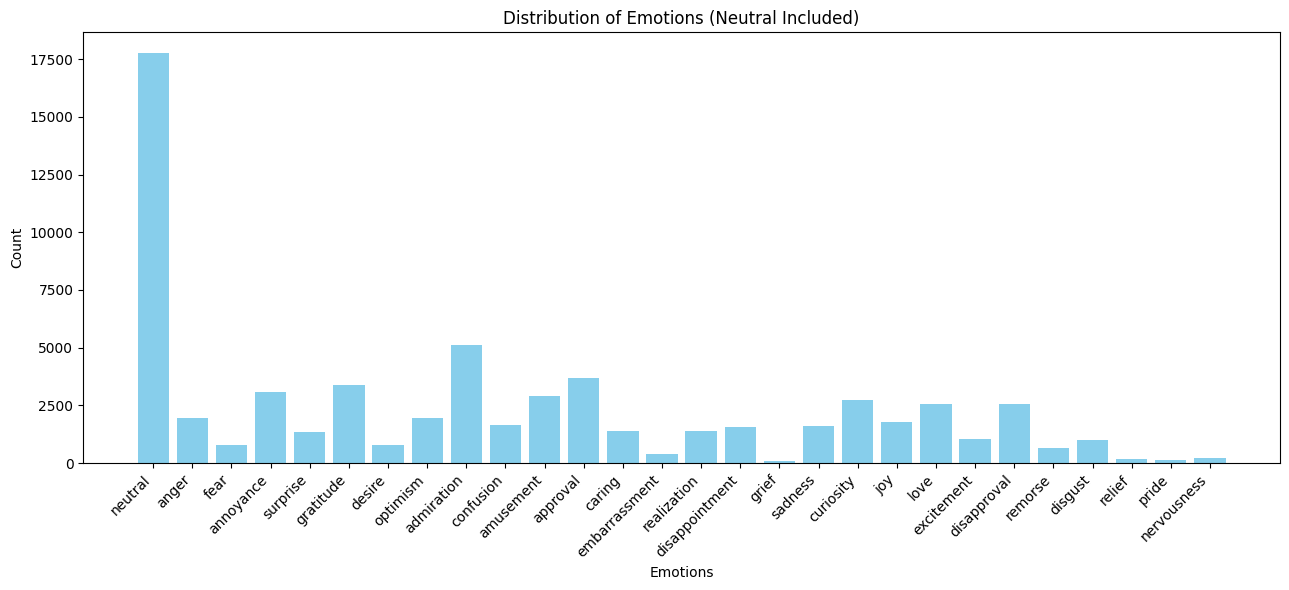

In [16]:
#visualise distribution of emotions within the dataset (Neutral Included)
all_labels=[label for labels in df_all['emotion_label'] for label in labels]
all_labels_count=Counter(all_labels)

plt.figure(figsize=(13, 6))
plt.bar(all_labels_count.keys(), all_labels_count.values(), color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions (Neutral Included)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

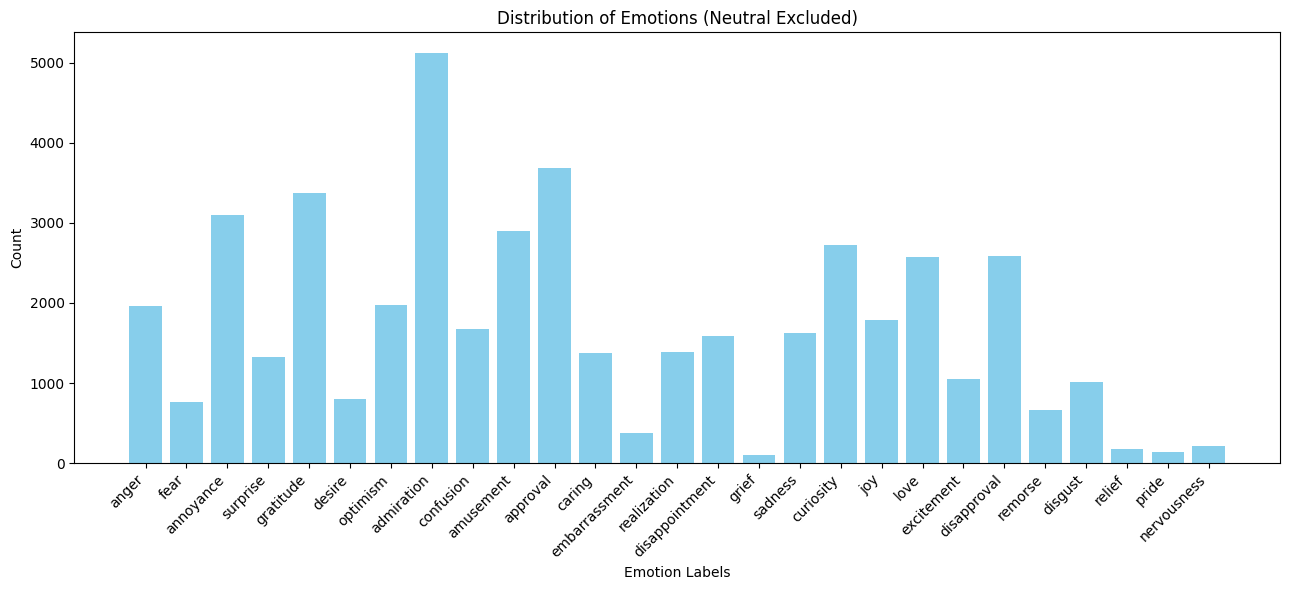

In [17]:
#visualise distribution of emotions within the dataset (Neutral Excluded)
all_labels_neu_excluded= [label for labels in df_all['emotion_label'] for label in labels if label != 'neutral']
neu_excluded_labels_count = Counter(all_labels_neu_excluded)

plt.figure(figsize=(13, 6))
plt.bar(neu_excluded_labels_count.keys(), neu_excluded_labels_count.values(), color='skyblue')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotions (Neutral Excluded)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

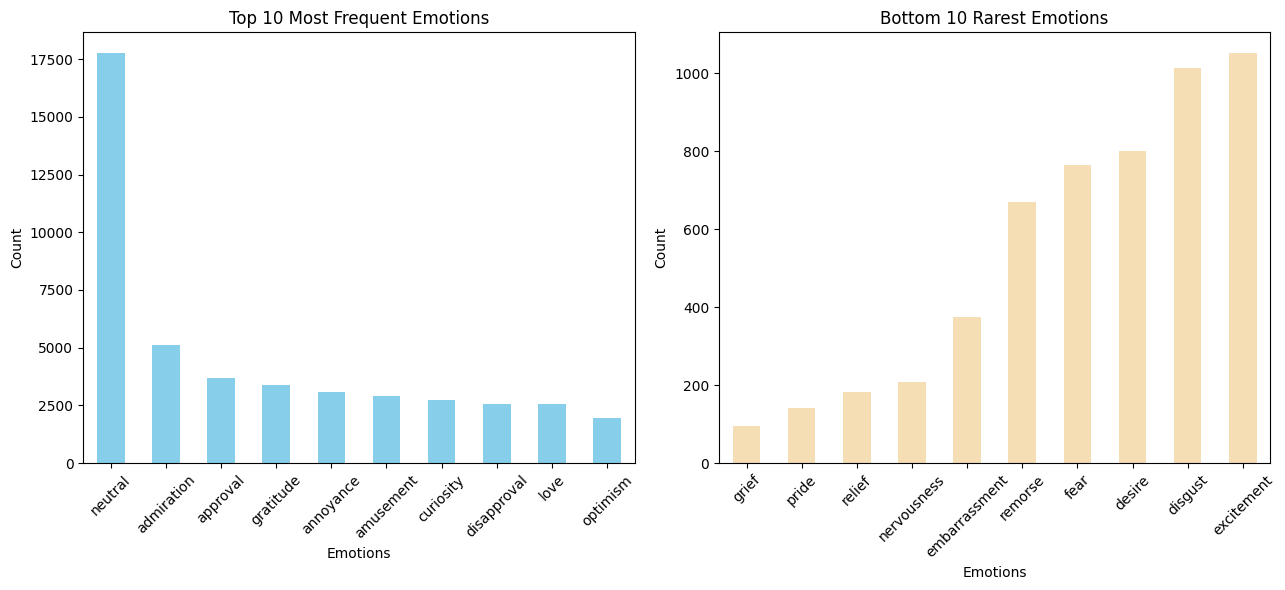

In [18]:
#visualise top/bottom 10 frequent/rare emotions

label_df = pd.DataFrame(all_labels_count.items(), columns=["emotion", "count"])
label_df = label_df.sort_values(by="count", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(13,6))

#top 10 most frequent emotions
label_df.head(10).plot(kind="bar", x="emotion", y="count", ax=axes[0], legend=False, color="skyblue")
axes[0].set_title("Top 10 Most Frequent Emotions")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Emotions")
axes[0].tick_params(axis='x', rotation=45)

#bottom 10 rare emotions
label_df.tail(10).sort_values("count").plot(kind="bar", x="emotion", y="count", ax=axes[1],legend=False, color="wheat")
axes[1].set_title("Bottom 10 Rarest Emotions")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Emotions")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


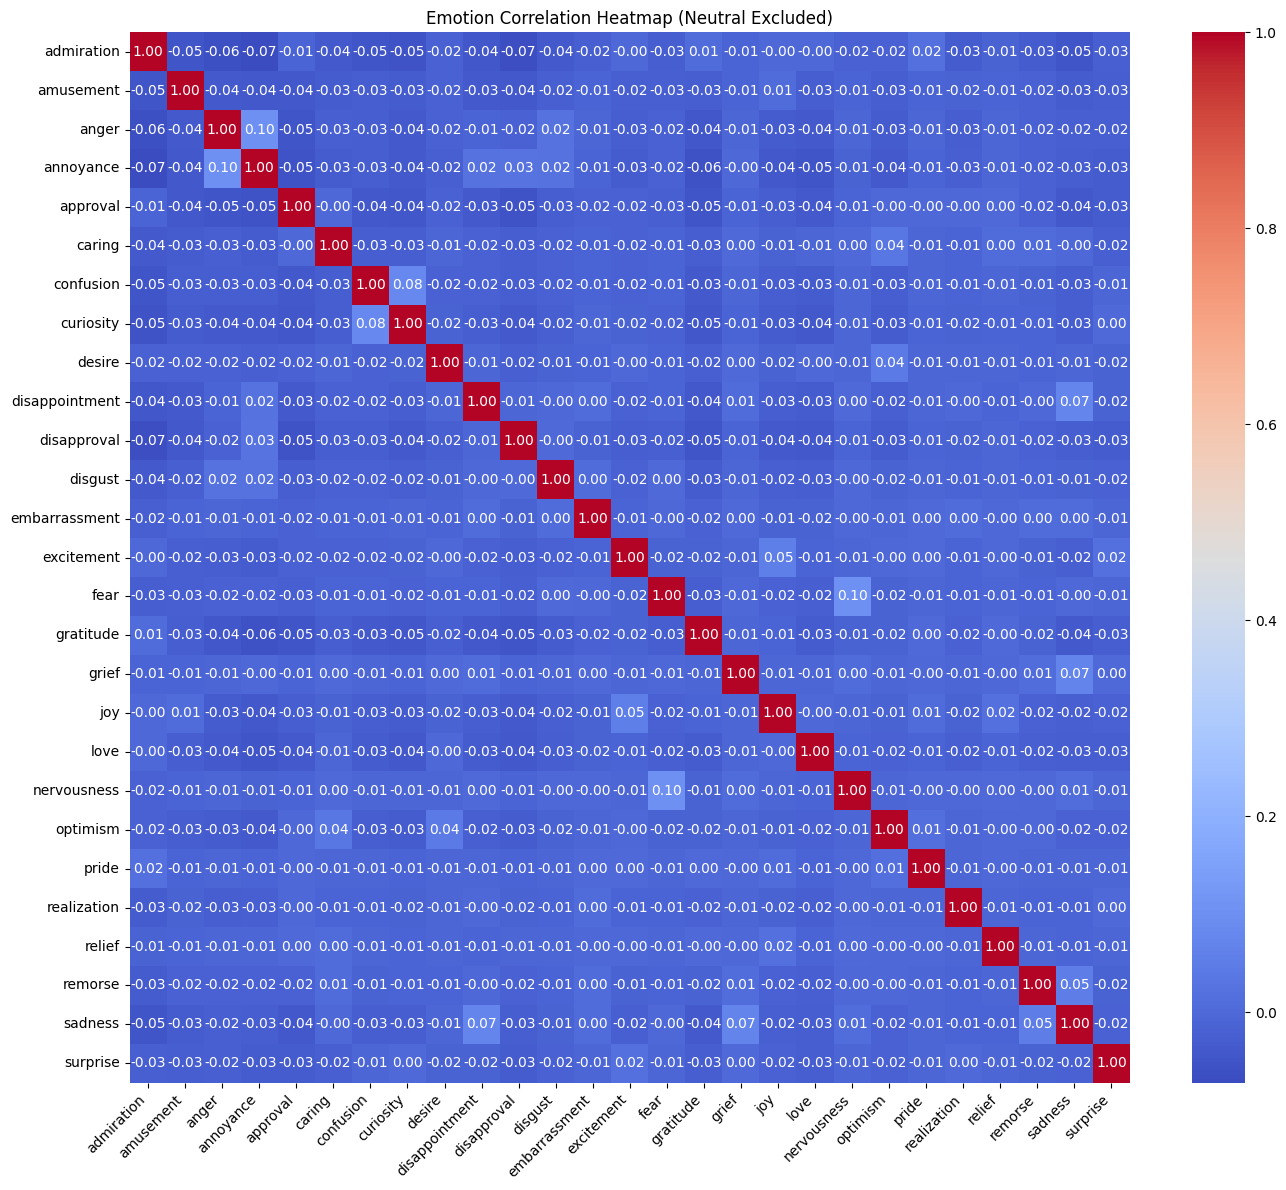

In [19]:
#plot emotion correlation heatmap
emotions_list = sorted({e for e in emotions[0] if e != 'neutral'})

binary_df = pd.DataFrame(0, index=df_all.index, columns=emotions_list)

for i, labels in enumerate(df_all['emotion_label']):
    for e in labels:
        if e != 'neutral':
            binary_df.at[i, e] = 1
corr_matrix = binary_df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Emotion Correlation Heatmap (Neutral Excluded)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

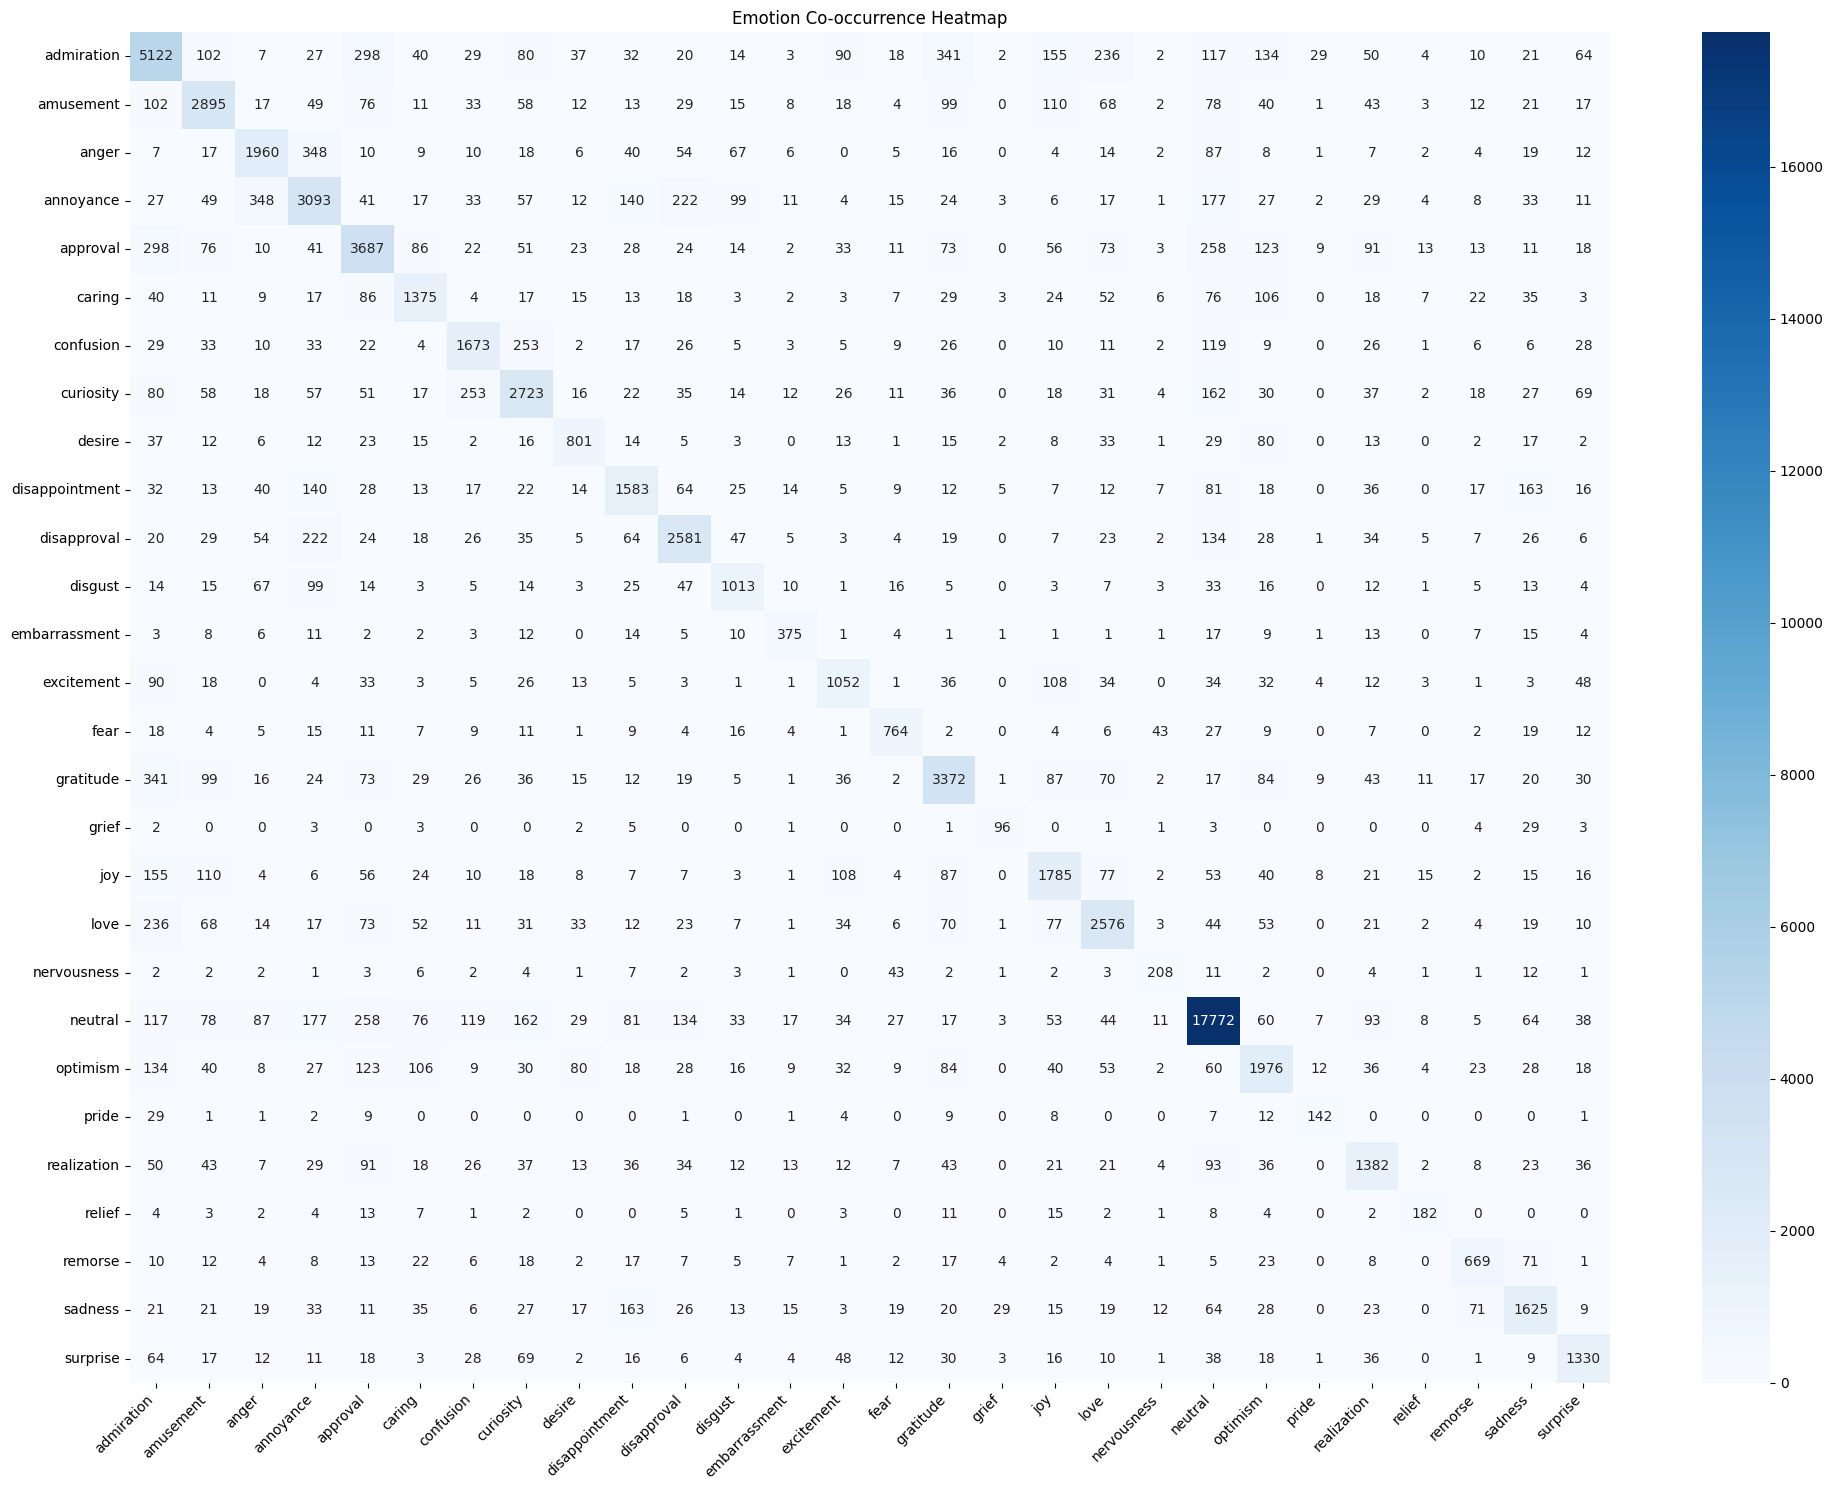

In [20]:
#visualise emotion co-occurrence across the dataset

mlb = MultiLabelBinarizer()

#convert emotion lists to binary matrix
labels_mh = mlb.fit_transform(df_all['emotion_label'])

#compute emotion co-occurrence counts
co_occurrence = labels_mh.T @ labels_mh
co_occurrence_df = pd.DataFrame(co_occurrence, index=mlb.classes_, columns=mlb.classes_)

plt.figure(figsize=(20, 15))
sns.heatmap(co_occurrence_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Emotion Co-occurrence Heatmap")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [21]:
#define emotion groupings based on valence-arousal categories
pleasant_active = ['joy', 'love', 'admiration', 'amusement', 'excitement', 'pride', 'approval', 'desire']
pleasant_deactive = ['gratitude', 'relief', 'caring', 'optimism']
unpleasant_active = ['anger', 'annoyance', 'fear', 'disgust', 'nervousness', 'disapproval']
unpleasant_deactive = ['sadness', 'disappointment', 'remorse', 'embarrassment', 'grief']
neutral_ambiguous = ['neutral', 'surprise', 'curiosity', 'realization', 'confusion']

#map an emotion to its valence-arousal category
def categorize_emotion(emotion):
    if emotion in pleasant_active:
        return 'pleasant_active'
    elif emotion in pleasant_deactive:
        return 'pleasant_deactive'
    elif emotion in unpleasant_active:
        return 'unpleasant_active'
    elif emotion in unpleasant_deactive:
        return 'unpleasant_deactive'
    else:
        return 'neutral_ambiguous'

In [22]:
#summarisation of total occurrences, alone vs co-occurring, and top-10 co-occurring emotions

top_num_emo = 10
emotion_data = []

#iterate over each emotion to compute text-level statistics
for emotion in mlb.classes_:

    #total num of texts containing this emotion
    total=int((df_all["emotion_label"].apply(lambda x: emotion in x)).sum())

    #num of texts where this emotion is the only label
    alone=int(df_all["emotion_label"].apply(lambda y: emotion in y and len(y) == 1).sum())

    #num of texts where this emotion appears with other emotions
    co_with_others = total - alone

    #get top 10 co-occurring emotions using the co-occurrence matrix
    top_co = co_occurrence_df.loc[emotion].drop(emotion).sort_values(ascending=False).head(top_num_emo)
    top_cols = {f"top{i+1}": f"{emo}({int(cnt)})" for i, (emo, cnt) in enumerate(top_co.items())}

    emotion_data.append({
        "emotion": emotion,
        "total": total,
        "alone": alone,
        "with_others": co_with_others,
        **top_cols,
        "category": categorize_emotion(emotion)
    })

df_co_occurrence_final = pd.DataFrame(emotion_data).set_index("emotion")

category_order = [
    'pleasant_active',
    'pleasant_deactive',
    'unpleasant_active',
    'unpleasant_deactive',
    'neutral_ambiguous'
]

#display summaries grouped by each emotion category
for cat in category_order:
    subset = df_co_occurrence_final[df_co_occurrence_final['category'] == cat]
    print(f"{cat.replace('_', ' ').title()} Emotions\n")
    display(subset)
    print("\n")

Pleasant Active Emotions



,total,alone,with_others,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,category
emotion,,,,,,,,,,,,,,
admiration,5122,3384,1738,gratitude(341),approval(298),love(236),joy(155),optimism(134),neutral(117),amusement(102),excitement(90),curiosity(80),surprise(64),pleasant_active
amusement,2895,2046,849,joy(110),admiration(102),gratitude(99),neutral(78),approval(76),love(68),curiosity(58),annoyance(49),realization(43),optimism(40),pleasant_active
approval,3687,2367,1320,admiration(298),neutral(258),optimism(123),realization(91),caring(86),amusement(76),gratitude(73),love(73),joy(56),curiosity(51),pleasant_active
desire,801,497,304,optimism(80),admiration(37),love(33),neutral(29),approval(23),sadness(17),curiosity(16),caring(15),gratitude(15),disappointment(14),pleasant_active
excitement,1052,619,433,joy(108),admiration(90),surprise(48),gratitude(36),love(34),neutral(34),approval(33),optimism(32),curiosity(26),amusement(18),pleasant_active
joy,1785,1052,733,admiration(155),amusement(110),excitement(108),gratitude(87),love(77),approval(56),neutral(53),optimism(40),caring(24),realization(21),pleasant_active
love,2576,1760,816,admiration(236),joy(77),approval(73),gratitude(70),amusement(68),optimism(53),caring(52),neutral(44),excitement(34),desire(33),pleasant_active
pride,142,67,75,admiration(29),optimism(12),approval(9),gratitude(9),joy(8),neutral(7),excitement(4),annoyance(2),anger(1),disapproval(1),pleasant_active




Pleasant Deactive Emotions



,total,alone,with_others,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,category
emotion,,,,,,,,,,,,,,
caring,1375,831,544,optimism(106),approval(86),neutral(76),love(52),admiration(40),sadness(35),gratitude(29),joy(24),remorse(22),realization(18),pleasant_deactive
gratitude,3372,2378,994,admiration(341),amusement(99),joy(87),optimism(84),approval(73),love(70),realization(43),curiosity(36),excitement(36),surprise(30),pleasant_deactive
optimism,1976,1087,889,admiration(134),approval(123),caring(106),gratitude(84),desire(80),neutral(60),love(53),joy(40),amusement(40),realization(36),pleasant_deactive
relief,182,103,79,joy(15),approval(13),gratitude(11),neutral(8),caring(7),disapproval(5),admiration(4),optimism(4),annoyance(4),amusement(3),pleasant_deactive




Unpleasant Active Emotions



,total,alone,with_others,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,category
emotion,,,,,,,,,,,,,,
anger,1960,1265,695,annoyance(348),neutral(87),disgust(67),disapproval(54),disappointment(40),sadness(19),curiosity(18),amusement(17),gratitude(16),love(14),unpleasant_active
annoyance,3093,1809,1284,anger(348),disapproval(222),neutral(177),disappointment(140),disgust(99),curiosity(57),amusement(49),approval(41),confusion(33),sadness(33),unpleasant_active
disapproval,2581,1809,772,annoyance(222),neutral(134),disappointment(64),anger(54),disgust(47),curiosity(35),realization(34),amusement(29),optimism(28),sadness(26),unpleasant_active
disgust,1013,635,378,annoyance(99),anger(67),disapproval(47),neutral(33),disappointment(25),fear(16),optimism(16),amusement(15),curiosity(14),admiration(14),unpleasant_active
fear,764,553,211,nervousness(43),neutral(27),sadness(19),admiration(18),disgust(16),annoyance(15),surprise(12),curiosity(11),approval(11),disappointment(9),unpleasant_active
nervousness,208,105,103,fear(43),sadness(12),neutral(11),disappointment(7),caring(6),realization(4),curiosity(4),approval(3),love(3),disgust(3),unpleasant_active




Unpleasant Deactive Emotions



,total,alone,with_others,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,category
emotion,,,,,,,,,,,,,,
disappointment,1583,888,695,sadness(163),annoyance(140),neutral(81),disapproval(64),anger(40),realization(36),admiration(32),approval(28),disgust(25),curiosity(22),unpleasant_deactive
embarrassment,375,246,129,neutral(17),sadness(15),disappointment(14),realization(13),curiosity(12),annoyance(11),disgust(10),optimism(9),amusement(8),remorse(7),unpleasant_deactive
grief,96,47,49,sadness(29),disappointment(5),remorse(4),neutral(3),surprise(3),annoyance(3),caring(3),admiration(2),desire(2),nervousness(1),unpleasant_deactive
remorse,669,437,232,sadness(71),optimism(23),caring(22),curiosity(18),gratitude(17),disappointment(17),approval(13),amusement(12),admiration(10),realization(8),unpleasant_deactive
sadness,1625,1003,622,disappointment(163),remorse(71),neutral(64),caring(35),annoyance(33),grief(29),optimism(28),curiosity(27),disapproval(26),realization(23),unpleasant_deactive




Neutral Ambiguous Emotions



,total,alone,with_others,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,category
emotion,,,,,,,,,,,,,,
confusion,1673,1057,616,curiosity(253),neutral(119),annoyance(33),amusement(33),admiration(29),surprise(28),disapproval(26),realization(26),gratitude(26),approval(22),neutral_ambiguous
curiosity,2723,1729,994,confusion(253),neutral(162),admiration(80),surprise(69),amusement(58),annoyance(57),approval(51),realization(37),gratitude(36),disapproval(35),neutral_ambiguous
neutral,17772,16021,1751,approval(258),annoyance(177),curiosity(162),disapproval(134),confusion(119),admiration(117),realization(93),anger(87),disappointment(81),amusement(78),neutral_ambiguous
realization,1382,749,633,neutral(93),approval(91),admiration(50),gratitude(43),amusement(43),curiosity(37),disappointment(36),surprise(36),optimism(36),disapproval(34),neutral_ambiguous
surprise,1330,902,428,curiosity(69),admiration(64),excitement(48),neutral(38),realization(36),gratitude(30),confusion(28),approval(18),optimism(18),amusement(17),neutral_ambiguous


In [23]:
#display overall frequency of each emotion category

emotion_counts = co_occurrence_df.values.diagonal()
emotion_names = co_occurrence_df.index.tolist()
freq_df = pd.DataFrame({
    'emotion': emotion_names,
    'count': emotion_counts
})
freq_df['category'] = freq_df['emotion'].apply(categorize_emotion)

#aggregate emotions at category level
category_counts = freq_df.groupby('category')['count'].sum().sort_values(ascending=False) #aggregate per category

print("\nFrequency per category:")
display(category_counts)


Frequency per category:


,count
category,
neutral_ambiguous,24880
pleasant_active,18060
unpleasant_active,9619
pleasant_deactive,6905
unpleasant_deactive,4348


In [24]:
#display emotion frequencies within each category
for cat in category_order:
    df_cat = freq_df[freq_df['category'] == cat].sort_values('count', ascending=False).reset_index(drop=True)
    df_cat = df_cat[['emotion', 'count']]
    print(f"\n{cat.replace('_', ' ').title()}")
    display(df_cat)


Pleasant Active


,emotion,count
0,admiration,5122
1,approval,3687
2,amusement,2895
3,love,2576
4,joy,1785
5,excitement,1052
6,desire,801
7,pride,142



Pleasant Deactive


,emotion,count
0,gratitude,3372
1,optimism,1976
2,caring,1375
3,relief,182



Unpleasant Active


,emotion,count
0,annoyance,3093
1,disapproval,2581
2,anger,1960
3,disgust,1013
4,fear,764
5,nervousness,208



Unpleasant Deactive


,emotion,count
0,sadness,1625
1,disappointment,1583
2,remorse,669
3,embarrassment,375
4,grief,96



Neutral Ambiguous


,emotion,count
0,neutral,17772
1,curiosity,2723
2,confusion,1673
3,realization,1382
4,surprise,1330


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


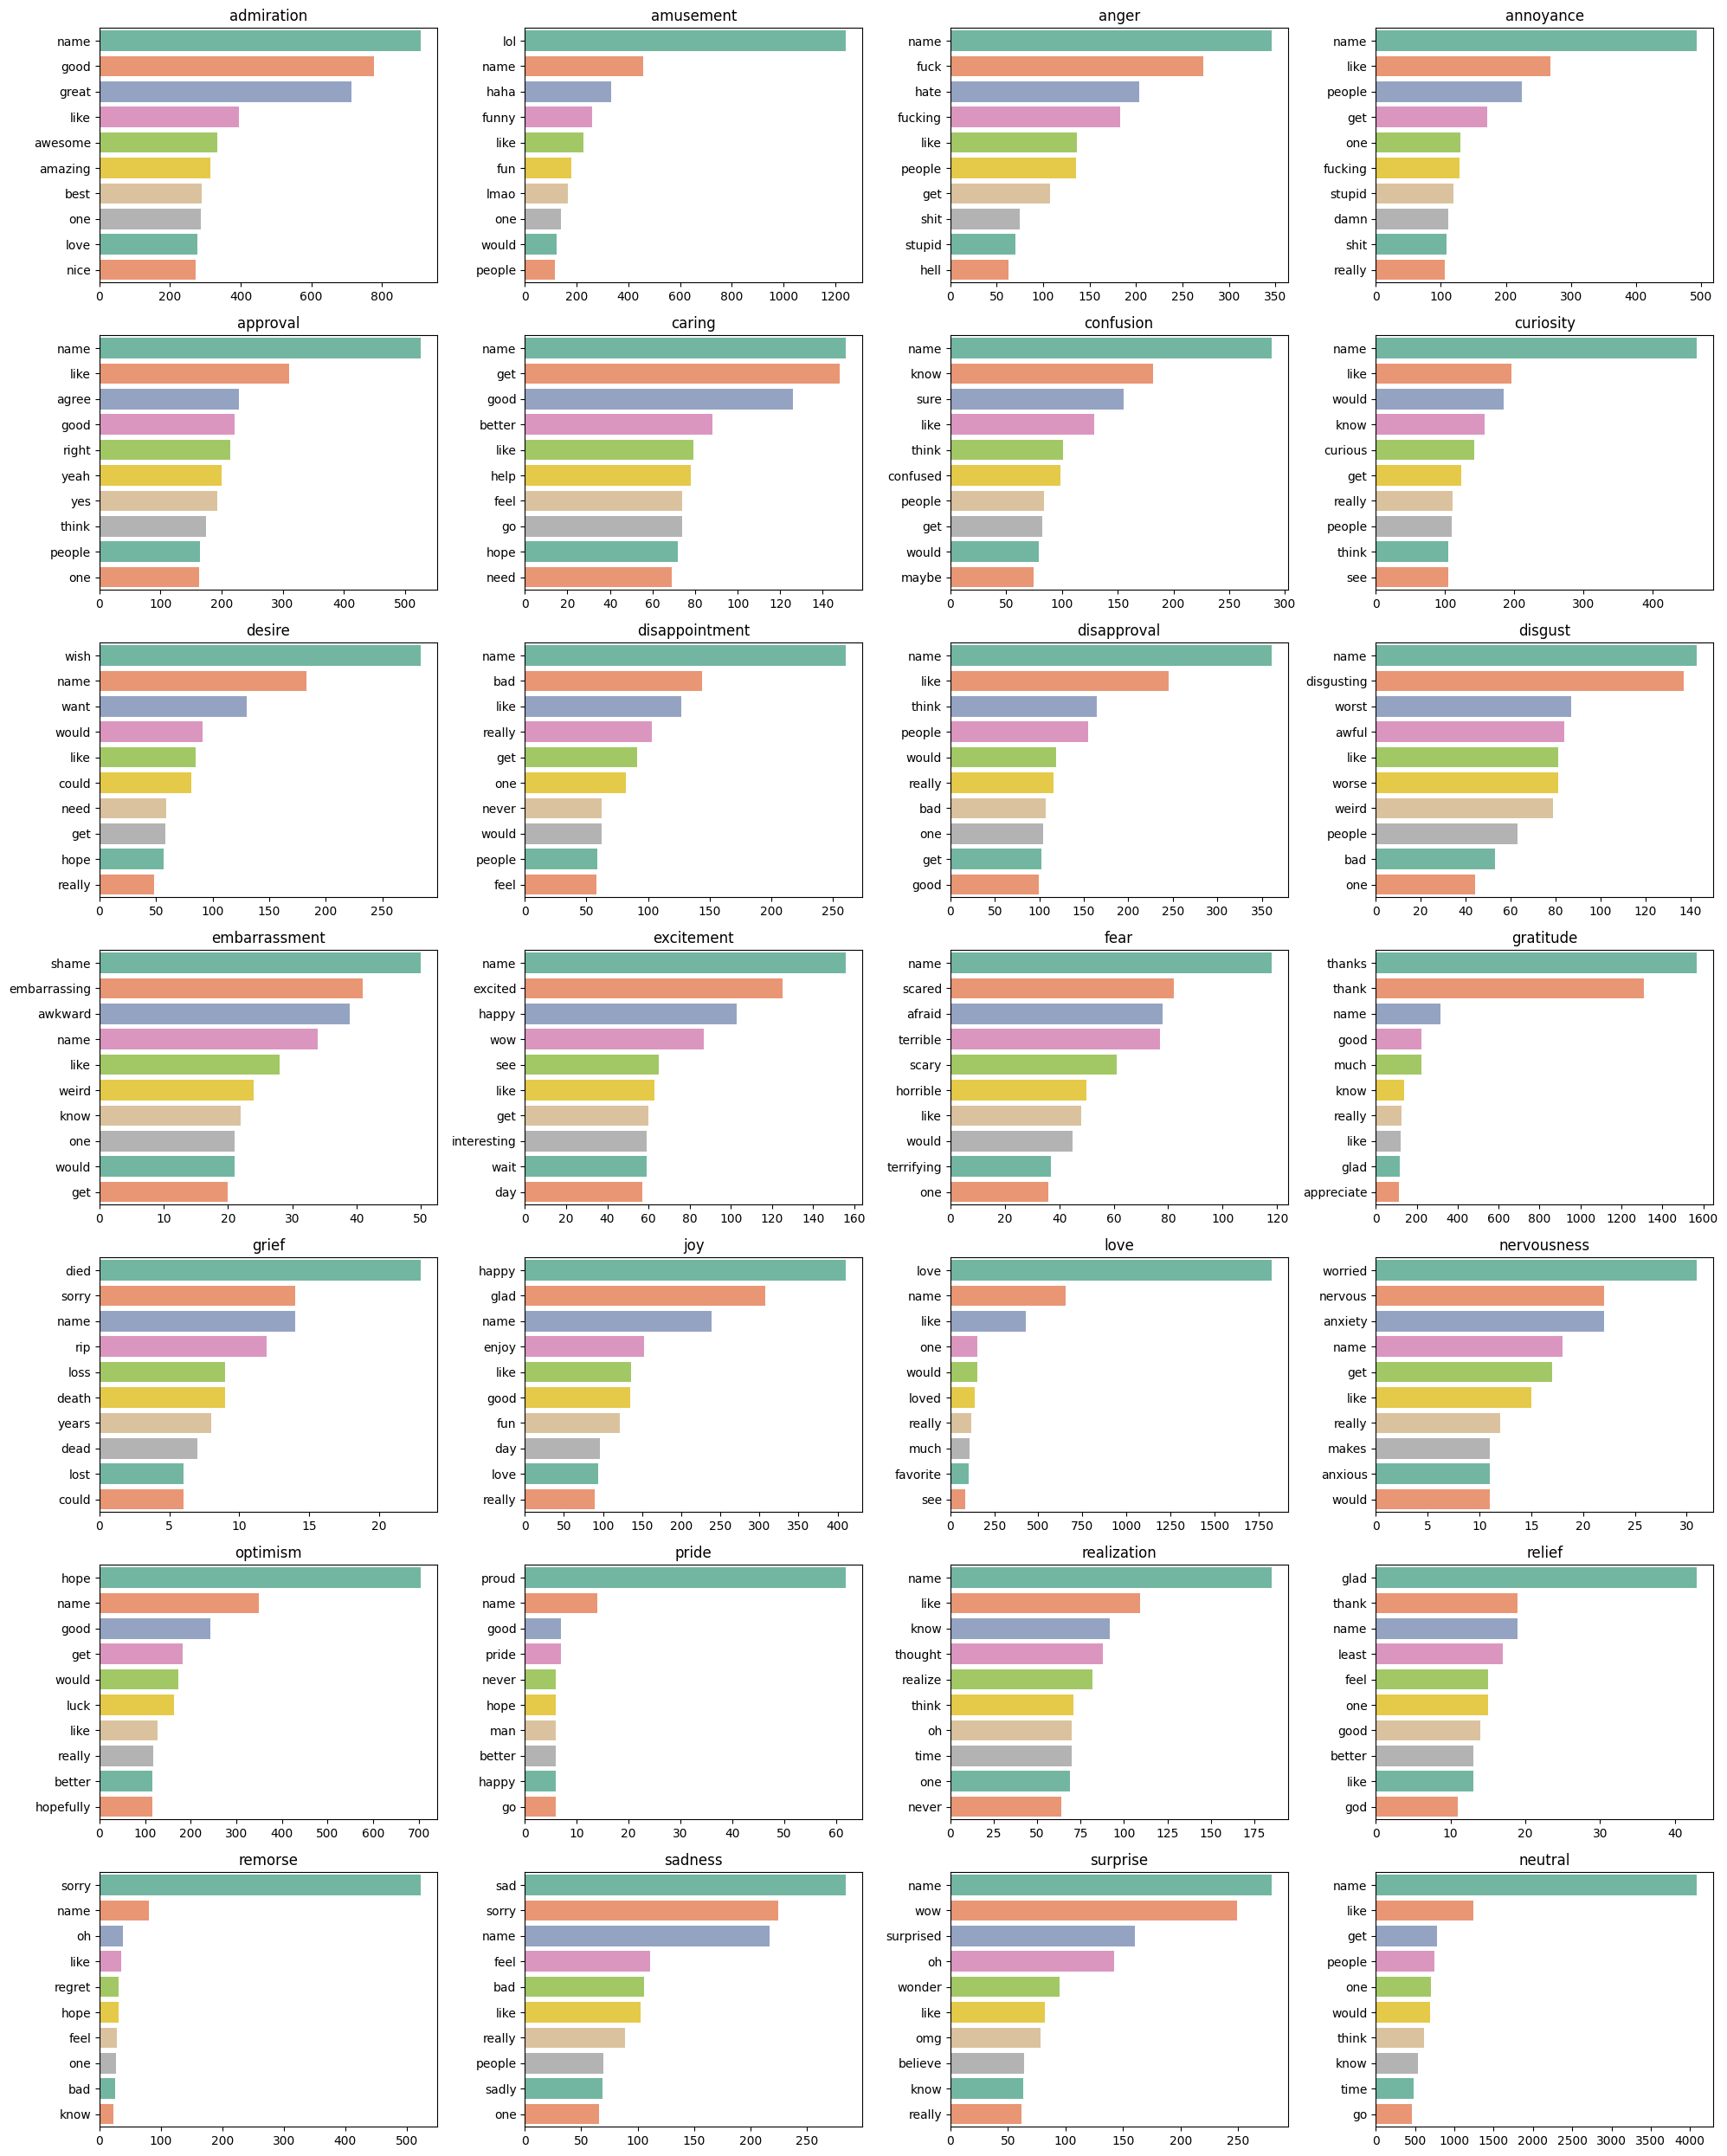

In [25]:
#visualise 10 most common (non-stopword) words associated with each emotion
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#compute most frequent words for texts containing a specified emotion
def most_common_words(emotion):
    texts = df_all[df_all['emotion_label'].apply(lambda x: emotion in x)]['text'] #select texts with specified emotion
    words = ' '.join(texts).lower()   #combine and lowercase all texts
    words = re.findall(r'\w+', words) #split into words
    words = [w for w in words if w not in stop_words] #remove stop words
    return Counter(words).most_common(10)

n_rows = 7
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,25))
axes = axes.flatten()

for i, emotion in enumerate(emotions[0]):
    common_words = most_common_words(emotion)
    if common_words:
        words, counts = zip(*common_words)
        sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette="Set2", hue=list(words), legend=False)
        axes[i].set_title(emotion)
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Text Length (Characters) Statistics:
Minimum length: 2
Maximum length: 703
Mean length: 68.33
Median length: 65.0



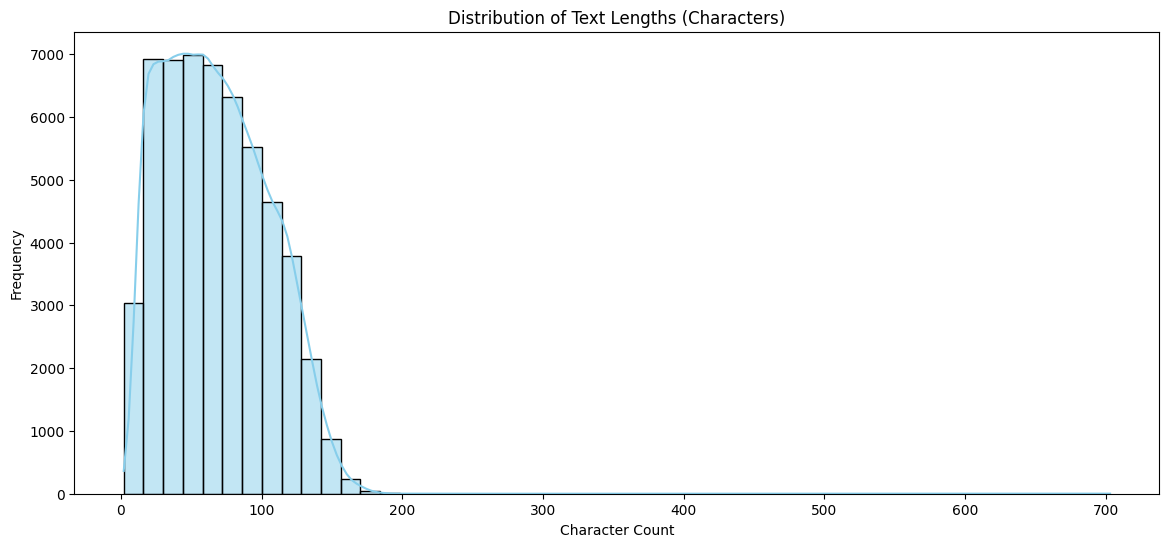

In [26]:
#total num of characters included in each text
df_all["char_count"] = df_all["text"].apply(len)

#print basic statistics of character counts
print("Text Length (Characters) Statistics:")
print(f"Minimum length: {df_all['char_count'].min()}")
print(f"Maximum length: {df_all['char_count'].max()}")
print(f"Mean length: {df_all['char_count'].mean():.2f}")
print(f"Median length: {df_all['char_count'].median()}\n")

plt.figure(figsize=(14,6))
sns.histplot(df_all["char_count"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Text Lengths (Characters)")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()


In [27]:
#identify extremely short and long texts based on character length

Q1 = np.percentile(df_all["char_count"], 25)
Q3 = np.percentile(df_all["char_count"], 75)
IQR = Q3 - Q1

#compute IQR-based bounds for long-text outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")

#identify very short texts and long text outliers
min_threshold = 5
short_outliers = df_all[df_all["char_count"] < min_threshold]
long_outliers = df_all[df_all["char_count"] > upper_bound]

#report counts and sample examples for inspection
print(f"\nNumber of extremely short texts (<{min_threshold} chars): {len(short_outliers)}")
print(f"Number of extremely long texts (>{upper_bound:.0f} chars): {len(long_outliers)}")

print("\nShort outlier examples:")
if len(short_outliers) > 0:
    print(short_outliers[["char_count", "text", "emotion_label"]].head(10).to_string(index=False))
else:
    print("No extremely short texts found.")

print("\nLong outlier examples:")
if len(long_outliers) > 0:
    print(long_outliers[["char_count", "text", "emotion_label"]].head(10).to_string(index=False))
else:
    print("No extremely long texts found.")


IQR: 58.00
Lower bound: -49.00
Upper bound: 183.00

Number of extremely short texts (<5 chars): 16
Number of extremely long texts (>183 chars): 11

Short outlier examples:
 char_count text    emotion_label
          4 Wow.       [surprise]
          4 nice        [neutral]
          4 Link        [neutral]
          3  art        [neutral]
          4 #YES        [neutral]
          4 Yes.       [approval]
          3  :^(        [neutral]
          4 Fuck [anger, disgust]
          4 here        [neutral]
          2   XD        [neutral]

Long outlier examples:
 char_count                                                                                                                                                                                                                                                                                                                                                                                                                                   

# 4.Text Cleaning and Preprocessing Setup

This section defines the text cleaning and preprocessing steps applied across baseline and transformer models.

## 4.1. Initial Cleaning and Deduplication

In [28]:
#drop comment_id column from all splits
train_df=train_df.drop(columns=["comment_id"])
test_df=test_df.drop(columns=["comment_id"])
val_df=val_df.drop(columns=["comment_id"])

In [29]:
#detect num of missing or empty text rows
text_is_null  = df_all["text"].isna()
text_is_blank = df_all["text"].astype(str).str.strip().eq("")
print(f"Total num of missing or empty text rows:", (text_is_null | text_is_blank).sum())

Total num of missing or empty text rows: 0


In [30]:
#check for missing text and/or emotion labels in each data split
def check_empty_text_or_emotion(df, split="split"):
    print(f"\n{split} Split:\n")

    total=len(df)

    #identify rows with missing text
    no_text=df["text"].isna()|df["text"].astype(str).str.strip().eq("")

    #identify rows with missing emotion id
    no_label=df["emotion_id"].isna()|df["emotion_id"].astype(str).str.strip().eq("")

    has_text_but_no_label=((~no_text)&(no_label)).sum()
    has_label_but_no_text=((no_text)&(~no_label)).sum()
    no_label_and_no_text=((no_text)&(no_label)).sum()


    print(f"Total num of rows: {total:,}")
    print(f"Num of rows with text but no emotion_id: {has_text_but_no_label:,}")
    print(f"Num of rows with emotion_id but no text: {has_label_but_no_text:,}")
    print(f"Num of rows with no emotion_id and no text: {no_label_and_no_text:,}")

check_empty_text_or_emotion(train_df, "Train")
check_empty_text_or_emotion(test_df, "Test")
check_empty_text_or_emotion(val_df, "Val")



Train Split:

Total num of rows: 43,410
Num of rows with text but no emotion_id: 0
Num of rows with emotion_id but no text: 0
Num of rows with no emotion_id and no text: 0

Test Split:

Total num of rows: 5,427
Num of rows with text but no emotion_id: 0
Num of rows with emotion_id but no text: 0
Num of rows with no emotion_id and no text: 0

Val Split:

Total num of rows: 5,426
Num of rows with text but no emotion_id: 0
Num of rows with emotion_id but no text: 0
Num of rows with no emotion_id and no text: 0


In [31]:
#check pure duplicates and duplicates with different emotion_ids

def check_duplicates(df, split="dataset"):
  print(f"\n{split} Split:\n")

  #identify rows where the same text appears more than once
  duplicates=df["text"].duplicated(keep=False)

  #group duplicated texts and collect unique labels for each text
  gp_unique_duplicates=df.loc[duplicates].groupby("text")["emotion_id"].agg(lambda s: sorted(pd.unique(s))).reset_index()
  if gp_unique_duplicates.empty:
      print("No duplicate texts.")
      return gp_unique_duplicates

  #add additional column that display num of labels each duplicated text has
  gp_unique_duplicates["num_unique_labels"]=gp_unique_duplicates["emotion_id"].apply(len)

  duplicates_diff_labels=gp_unique_duplicates[gp_unique_duplicates["num_unique_labels"]>1]
  real_duplicates=gp_unique_duplicates[gp_unique_duplicates["num_unique_labels"]==1]

  print(f"Total num of texts with duplicates: {len(gp_unique_duplicates):,}")
  print(f"Num of same text with different emotion_id: {len(duplicates_diff_labels):,}")
  print(f"Num of pure duplicates: {len(real_duplicates)}")

#run the duplicate check for each data split
check_duplicates(train_df, "Train")
check_duplicates(test_df, "Test")
check_duplicates(val_df, "Val")


Train Split:

Total num of texts with duplicates: 118
Num of same text with different emotion_id: 58
Num of pure duplicates: 60

Test Split:

Total num of texts with duplicates: 5
Num of same text with different emotion_id: 1
Num of pure duplicates: 4

Val Split:

Total num of texts with duplicates: 2
Num of same text with different emotion_id: 1
Num of pure duplicates: 1


In [32]:
#merge emotion labels for duplicated texts with different emotion_ids

def merge_unique_duplicates(df, split="dataset"):
  num_before_merging=len(df)

  #convert the emotion_id values to a list
  def to_list(x):
      if pd.isna(x):
        return []
      if isinstance(x, int):
        return [x]
      if isinstance(x, str):
        x=x.strip()
        if not x:
          return []
        return [int(i) for i in x.split(',') if i]
      return []

  temp_df = df.copy()
  temp_df["emotion_id"] = temp_df["emotion_id"].apply(to_list)

  merged_df=(
      temp_df.groupby("text", as_index=False).agg({
          "emotion_id": lambda s: sorted(set(e for lst in s for e in lst))
      })
  )
  return merged_df

In [33]:
#merge train split and deduplicate test/val splits to avoid data leakage

ws_re = re.compile(r"\s+") #matches and collapse whitespaces

#create a deduplicate key by normalizing text to ensure duplicates can be identified across all splits
def deduplicate_key(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return ws_re.sub(" ", html.unescape(s).lower()).strip()

#merge duplicate texts in train split and apply deduplication key
train_merged = merge_unique_duplicates(train_df, "Train")
train_merged["key"] = train_merged["text"].apply(deduplicate_key)

#deduplicate val and test splits, keep the first occurence, and apply deduplication key
val_deduplicate  = val_df.drop_duplicates(subset=["text"], keep="first").copy()
test_deduplicate = test_df.drop_duplicates(subset=["text"], keep="first").copy()

val_deduplicate["key"]  = val_deduplicate["text"].apply(deduplicate_key)
test_deduplicate["key"] = test_deduplicate["text"].apply(deduplicate_key)

#remove texts in val/test that also appear in train to avoid data leakage
train_keys = set(train_merged["key"])
val_final  = val_deduplicate[~val_deduplicate["key"].isin(train_keys)].reset_index(drop=True)
test_final = test_deduplicate[~test_deduplicate["key"].isin(train_keys)].reset_index(drop=True)

#remove deduplication key and retain original columns
train_final = train_merged[["text", "emotion_id"]].copy()
val_final   = val_final[["text", "emotion_id"]].copy()
test_final  = test_final[["text", "emotion_id"]].copy()

print(f"Train Split: {len(train_df):,}, after merging: {len(train_final):,}")
print(f"Test Split: {len(test_df):,}, after removing overlaps: {len(test_final):,} (overlaps removed: {len(test_df)-len(test_final):,})")
print(f"Val Split: {len(val_df):,}, after removing overlaps: {len(val_final):,}  (overlaps removed: {len(val_df)-len(val_final):,})")

Train Split: 43,410, after merging: 43,227
Test Split: 5,427, after removing overlaps: 5,384 (overlaps removed: 43)
Val Split: 5,426, after removing overlaps: 5,376  (overlaps removed: 50)


In [34]:
#confirm again that val and test splits share no texts with training data
assert not set(val_final["text"].apply(deduplicate_key)).intersection(set(train_final["text"].apply(deduplicate_key)))
assert not set(test_final["text"].apply(deduplicate_key)).intersection(set(train_final["text"].apply(deduplicate_key)))

## 4.2 Handling Text Artifacts

In [35]:
#check the presence of html entities (&, <,>, ",', space) in all splits
html_entities=df_all['text'].str.contains(r"&(?:amp|lt|gt|quot|apos|nbsp);").any()

#check the presence of zero_width characters in all splits
zero_width_char=df_all['text'].str.contains(r"[\u0000-\u001F\u007F\u200B-\u200F\uFEFF\u115F\u1160\u3164\uFFA0\uFFFC\uFFF0-\uFFF8]").any()

print("Presence of HTML entities within all three splits:", html_entities)
print("Presence of zero_width characters within all three splits:", zero_width_char)

Presence of HTML entities within all three splits: False
Presence of zero_width characters within all three splits: True


In [36]:
#check count of patterns (emails, @-sign tokens, hashtags, reddit references, placeholders) within the text across all splits

regex_patterns = {

    #matches emails
    "emails": r"""(?ix)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b""",

    #matches @ at the front of the word
    "at_sign_front": r"(?<!\w)@[A-Za-z0-9_][A-Za-z0-9_-]*",

    #matches @ inside the word, e.g., t@gged
    "at_sign_inside":r"\b\w*@\w*\b",

    #matches hashtags at the front of the word
    "hashtags_front": r"(?<!\w)#[A-Za-z0-9_][A-Za-z0-9_-]*",

    #matches hashtags inside the word, e.g., t#gged
    "hashtags_inside":r"\b\w+#\w+\b",

    #matches placeholders within [], <>
    "placeholders": r"(?i)(\[\s*[a-z0-9_-]+\s*\]|<\s*[a-z0-9_-]+\s*>)",

    #matches subreddits references e.g., r/xxx
    "subreddits": r"\br/[A-Za-z0-9_]+",

    #matches reddit users references e.g., u/xxx
    "user_subreddits":r"\bu/[A-Za-z0-9_-]+",
}

#extract and count regex pattern occurrences
def extract_and_count(df, text, pattern):
    regex = re.compile(pattern)
    vals = df[text].astype(str).apply(lambda x: regex.findall(x)).explode()
    counts = vals.value_counts(dropna=True).to_frame(name="count")
    return counts

for name, pattern in regex_patterns.items():
    counts = extract_and_count(df_all, "text", pattern)
    print(f"\n\n{name.upper()}:")
    display(counts)




EMAILS:


,count
text,




AT_SIGN_FRONT:


,count
text,
@11,1
@teamYouTube,1
@teamyoutube,1
@me,1
@IAMTHESmoothOperator,1
@AOC,1
@lies_about_flossing,1




AT_SIGN_INSIDE:


,count
text,
t@gged,1




HASHTAGS_FRONT:


,count
text,
#1,32
#2,8
#I,4
#4,3
#YES,3
...,...
#calledyourbluff,1
#12,1
#face-support,1




HASHTAGS_INSIDE:


,count
text,
xkcd#37,1




PLACEHOLDERS:


,count
text,
[NAME],9598
[RELIGION],132
[serious],2
[get_user_id],1
<smile>,1
[ALL],1
[goshdarn],1
[TEAM],1
[chuckles],1




SUBREDDITS:


,count
text,
r/politics,8
r/woooosh,6
r/funny,6
r/nba,5
r/niceguys,4
...,...
r/rant,1
r/zach,1
r/stlouis,1




USER_SUBREDDITS:


,count
text,
u/iBiteYou,1
u/The_White_Baron,1
u/Dr-Pepper-Phd,1
u/Reijka92,1
u/HAHAAN00B,1
...,...
u/wikilacks,1
u/Skraxx,1
u/hyunL,1


In [37]:
#handle emails, and at_sign tokens (at the front and inside of words)

def handle_email_atSigns(text: str) -> str:

  #matches emails
  email_re = re.compile(r"""(?ix)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b""")

  #matches '@' at the front of word
  atSign_front_re= re.compile(r"(?<!\w)@[A-Za-z0-9_][A-Za-z0-9_-]*")

  #matches '@' inside words
  atSign_inside_re=re.compile(r"(?<=\w)@(?=\w)")

  text = email_re.sub(" <EMAIL> ", text)       #maps emails to <EMAIL>
  text = atSign_front_re.sub(" <USER> ", text) #maps to <USER> as '@' at the fron of word indicate mentions and tagged accounts
  text = atSign_inside_re.sub(" ", text)       #replace @ within the word with a whitespace
  text = re.sub(r"\s+", " ", text).strip()     #clean up whitespaces after replacing
  return text

In [38]:
#handle hashtags (at the front and inside of words)

def handle_hashtags(text: str) -> str:

  #matches words with '#' inside texts
  hashtag_inside_re=re.compile(r"(?<=\w)#(?=\w)")

  #matches words starting with '#'
  hashtag_start_re = re.compile(r"(?<!\w)#[A-Za-z0-9_][A-Za-z0-9_-]*")

  text = hashtag_inside_re.sub(" ", text) #replace hashtags inside the word with space
  text = hashtag_start_re.sub("", text)   #remove hashtag at the front of word

  return re.sub(r"\s+", " ", text).strip()

In [39]:
#handle placeholders

def handle_placeholders(text: str) -> str:

  #matches placeholders with [], and <>
  placeholder_re = re.compile(r"(?i)(\[\s*[a-z0-9_-]+\s*\]|<\s*[a-z0-9_-]+\s*>)")

  placeholder_map={

    #remove noise entirely
    "deleted": "", "get_user_id": "", "7": "", "t": "","all": "",

    #keep words that could provide emotion context
    "serious": "serious", "chuckles": "chuckles", "smile": "smile", "goshdarn": "goshdarn", "nice": "nice",

    #keep the placeholders
    "celebrity": "<ENTITY>", "name": "<NAME>", "religion": "<RELIGION>", "team": "<TEAM>",}

  def strip_brackets(s):
      key = s.group(0).strip("[]<>").strip().lower()
      val = placeholder_map.get(key, "")
      return f" {val} " if val else " "
  return placeholder_re.sub(strip_brackets, text)

In [40]:
#handle subreddit(e.g., r/xxx) and reddit users(e.g., u/xxx) references

def handle_subreddit_redditUsers(text: str) -> str:

  #matches subreddits
  subreddits_re=re.compile(r"\br/[A-Za-z0-9_]+")

  #matches reddit users
  reddit_user_re=re.compile(r"\bu/[A-Za-z0-9_-]+")

  text = subreddits_re.sub(" <SUBREDDIT> ", text)  #replace subreddit references (e.g., r/funny) with <SUBREDDIT> as they are identifiers
  text = reddit_user_re.sub(" <USER> ", text)      #replace reddit user references (e.g., u/iBiteYou) with <USER> as they are identifiers
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [41]:
#additional regex patterns

#matches real url
url_re=re.compile(r"https?://\S+|www\.\S+")

#matches zero-width characters
invisible_char_re=re.compile(r"[\u0000-\u001F\u007F\u200B-\u200F\uFEFF\u115F\u1160\u3164\uFFA0\uFFFC\uFFF0-\uFFF8]")

#matches words including the ones containing apostrophes'
word_re = re.compile(r"[a-zA-Z']+")

## 4.3. Handling Emoticons and Emojis

In [42]:
#map emoticons to their corresponding words

emoticons_to_words=[
    (re.compile(r"<3"), "love"),                              # <3
    (re.compile(r"\^_\^"), "smile"),                          # ^_^
    (re.compile(r"\*_\*"), "starstruck"),                     # *_*
    (re.compile(r">_\<"), "frustrated"),                      # >__<
    (re.compile(r"(?<!\w)[xX][dD](?!\w)"), "laugh"),          #XD, xd, Xd, xD
    (re.compile(r"(?<!\S):-?\)"), "smile"),                   # :) :-)
    (re.compile(r"(?<!\S):'\("), "cry"),                      # :'(
    (re.compile(r"(?<!\S):-?D"), "grin"),                     # :D :-D
    (re.compile(r"(?<!\S);-?\)"), "wink"),                    # ;) ;-)
    (re.compile(r"(?<!\S):-?\("), "sad"),                     # :( :-(
    (re.compile(r"(?<!\S):-?P\b", re.IGNORECASE), "playful"), # :P :-P
    (re.compile(r"(?<!\S):-?/",  re.IGNORECASE), "skeptical"),# :/ :-/
    (re.compile(r"(?<!\S):-?\\", re.IGNORECASE), "skeptical"),# :\ :-\
    (re.compile(r"(?<!\S):-?[oO]"), "surprised"),             # :o
    (re.compile(r"(?<!\S):-?\|"), "unimpressed"),             # :| :-|
]

#function for replacing emoticons with words
def replace_emoticons(text: str) -> str:
  for emo, p in emoticons_to_words:
      text = emo.sub(p, text)
  return text

In [43]:
#install emoji library
!pip -q install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.7 MB/s eta 0:00:00


In [44]:
#demojise sample testing
import emoji

text = "I am happy ☺️✨"
print("raw:", text)
print("demojized:", emoji.demojize(text, language="en"))

raw: I am happy ☺️✨
demojized: I am happy :smiling_face::sparkles:


## 4.4.Text Cleaning Pipelines for Transformer and Baseline Models

In [45]:
#text cleaning function for transformers

def clean_for_transformer(text: str) -> str:
    if not isinstance(text, str): return ""
    text = unicodedata.normalize("NFC", text)
    text = html.unescape(text)
    text = invisible_char_re.sub("", text)
    text = handle_placeholders(text)
    text = url_re.sub(" <URL> ", text)
    text = handle_email_atSigns(text)
    text = handle_hashtags(text)
    text = handle_subreddit_redditUsers(text)
    text = ws_re.sub(" ", text).strip()
    return text

In [46]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#set up lemmatisation and stopword handling for baseline text cleaning
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
negation_words = {"no", "not", "never", "n't", "cannot", "neither", "nor", "none"}
stop_words -= negation_words

#text cleaning for baseline
def clean_for_baseline(s: str) -> str:
    if not isinstance(s, str): return ""

    #perform the same initial transformer cleaning function
    s = clean_for_transformer(s)

    #map emoticons to words
    s = replace_emoticons(s)

    #demojize and remove : and _ from demojized words
    s = emoji.demojize(s, language="en")
    s = s.replace(":", " ")
    s = s.replace("_", " ")

    #map common punctuation cues to tokens
    markers = []
    if "?" in s: markers.append("__QUESTION_MARK__")
    if "!" in s: markers.append("__EXCLAIM__")
    if "..." in s: markers.append("__ELLIPSIS__")

    #lowercase,replace non letters with space and strip whitespaces
    s = s.lower()
    s = re.sub(r"[^a-z'\s]", " ", s)
    s = ws_re.sub(" ", s).strip() #strip whitespaces again as demojising and emoticon handling could introduce additional whitespaces

    #remove repeated punctuation and characters
    repeated_punc  = re.compile(r"([!?.,])\1{2,}") #match punctuations repeated 3+ times
    repeated_chars = re.compile(r"(.)\1{2,}")      #match chars repeated 3+ times
    s = repeated_chars.sub(r"\1\1", s)   #reduce repeated chars (3+ occureneces) to exactly 2 chars (e.g., Hiiiiii-> Hii)
    s = repeated_punc.sub(r"\1\1\1", s)  #reduce repeated punctuations (3+ occureneces) to exactly 3 symbols (e.g., Hi!!!!!!!!-> Hi!!!)

    #tokenize, lemmatize and stopwords removal
    toks = word_re.findall(s)
    toks = [lemmatizer.lemmatize(t) for t in toks if t not in stop_words]

    #add puncutation markers back to tokens
    toks.extend(markers)

    return " ".join(toks)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [47]:
#sample testing to verify that the cleaning functions behave as expected
samples = [
    "Hi @Alice, email me at bob@example.com! #HappyDay",
    "Check this: https://ex.am/ple &amp; r/funny u/someUser",
    "Emoji ✨😊 + emoticon :-D ...wow!!!",
    "Inline hash covid#19 and start #Grateful #2024",
    "Zero\u200Bwidth here &nbsp; and <smile> [name] says hi",
]

#transformer-style cleaning
print("clean_for_transformer")
for s in samples:
    print("RAW: ", s)
    print("TRF:", clean_for_transformer(s))
    print("-"*60)

#baseline-style cleaning
print("\nclean_for_baseline")
for s in samples:
    print("RAW: ", s)
    print("BASE:", clean_for_baseline(s))
    print("-"*60)


clean_for_transformer
RAW:  Hi @Alice, email me at bob@example.com! #HappyDay
TRF: Hi <USER> , email me at <EMAIL> !
------------------------------------------------------------
RAW:  Check this: https://ex.am/ple &amp; r/funny u/someUser
TRF: Check this: <URL> & <SUBREDDIT> <USER>
------------------------------------------------------------
RAW:  Emoji ✨😊 + emoticon :-D ...wow!!!
TRF: Emoji ✨😊 + emoticon :-D ...wow!!!
------------------------------------------------------------
RAW:  Inline hash covid#19 and start #Grateful #2024
TRF: Inline hash covid 19 and start
------------------------------------------------------------
RAW:  Zero​width here &nbsp; and <smile> [name] says hi
TRF: Zerowidth here and smile <NAME> says hi
------------------------------------------------------------

clean_for_baseline
RAW:  Hi @Alice, email me at bob@example.com! #HappyDay
BASE: hi user email email __EXCLAIM__
------------------------------------------------------------
RAW:  Check this: https://ex.

# 5.Dataset Preparation for Modeling

This section prepares model-ready datasets by encoding labels and structuring text data for use with baseline and transformer models.

## 5.1. Convert Emotion IDs, and Map Emotion Ids with Corresponding Labels

In [48]:
#convert the emotion_id of test and val splits into list of ints separated by commas

for df in [val_final, test_final]:
  df["emotion_id"] = df["emotion_id"].astype(str).apply(
      lambda x: [int(e) for e in x.split(',') if e.strip().isdigit()]
  )

  #the emotion_id column of train_final has already been converted into list separated by commas, therefore, in this step only the emotion_id of val_df and test_df were converted

In [49]:
#map emotion_ids with their corresponding emotion labels
for df in [train_final, val_final, test_final]:
  df["emotion_label"] = df["emotion_id"].apply(
      lambda ids: [emotions.iloc[i, 0] for i in ids])

In [50]:
train_final.head()

,text,emotion_id,emotion_label
0,"""If you don't wear BROWN AND ORANGE...YOU DON...","[3, 27]","[annoyance, neutral]"
1,"""What do Scottish people look like?"" How I wo...","[7, 18]","[curiosity, love]"
2,"### A surprise, to be sure, but a welcome one",[26],[surprise]
3,"'*Pray*, v. To ask that the laws of the unive...",[27],[neutral]
4,">it'll get invaded by tankie, unfortunately. ...",[27],[neutral]


## 5.2. Encode Labels

In [51]:
#label encoding

#fit the label binarizer on the train split to learn all emotion classes
mlb.fit(train_final["emotion_label"])

#transform emotion labels into binary columns in all splits
for df in [train_final, val_final, test_final]:
  df_labels=pd.DataFrame(mlb.transform(df["emotion_label"]), columns=mlb.classes_, index=df.index)
  df[mlb.classes_]=df_labels

In [52]:
train_final.head()

,text,emotion_id,emotion_label,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...","[3, 27]","[annoyance, neutral]",0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...","[7, 18]","[curiosity, love]",0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",[26],[surprise],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",[27],[neutral],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",[27],[neutral],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## 5.3. Drop Columns & Add Cleaned Text Columns for Baseline and Transformers

In [53]:
#drop emotion_id and emotion_label across all splits
for df in [train_final, test_final, val_final]:
    df.drop(columns=["emotion_id", "emotion_label"], inplace=True)

In [54]:
train_final.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [55]:
#add two columns of cleaned texts: one for transformers and the other for baseline
for df in [train_final, test_final, val_final]:
  df["text_transformer"] = df["text"].apply(clean_for_transformer)
  df["text_baseline"] = df["text"].apply(clean_for_baseline)


In [56]:
train_final.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,neutral,optimism,pride,realization,relief,remorse,sadness,surprise,text_transformer,text_baseline
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,"""If you don't wear BROWN AND ORANGE...YOU DON'...",wear brown orange matter need tshirt asap __EX...
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,"""What do Scottish people look like?"" How I wou...",scottish people look like would love take swin...
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"### A surprise, to be sure, but a welcome one",surprise sure welcome one
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,"'*Pray*, v. To ask that the laws of the univer...",' pray v ask law universe annulled behalf sing...
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,">it'll get invaded by tankie, unfortunately. H...",get invaded tankie unfortunately apropos


## 5.4. Prepare Input Features & Target Arrays for Baseline and Transformers


In [57]:
#prepare two versions of text inputs, one for baseline models and one for transformers
X_train_baseline=train_final["text_baseline"].tolist()
X_test_baseline=test_final["text_baseline"].tolist()
X_val_baseline=val_final["text_baseline"].tolist()

X_train_transformer=train_final["text_transformer"].tolist()
X_test_transformer=test_final["text_transformer"].tolist()
X_val_transformer=val_final["text_transformer"].tolist()

In [58]:
#prepare target arrays, shared by both baseline and transformers
label_cols = emotions[0].tolist()
y_train = train_final[label_cols].to_numpy(dtype="float32")
y_test = test_final[label_cols].to_numpy(dtype="float32")
y_val = val_final[label_cols].to_numpy(dtype="float32")

## 5.5. Convert Text to TF-IDF Features for Baseline Models


In [59]:
#vectorisation using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(
    max_features=45000,
    ngram_range=(1,2),
    min_df=2
)
X_train_tfidf=tfidf.fit_transform(X_train_baseline)
X_val_tfidf=tfidf.transform(X_val_baseline)
X_test_tfidf=tfidf.transform(X_test_baseline)

# 6.Creation of Shared Utility Module (utils.py)


This section defines a shared utils.py module with helper functions for evaluation, thresholding, and visualisation.

In [60]:
#write shared utility functions to utils.py
%%writefile /content/drive/MyDrive/applied_research_project/utils.py

import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#define emotion groupings based on valence-arousal categories
pleasant_active = ['joy', 'love', 'admiration', 'amusement', 'excitement', 'pride', 'approval', 'desire']
pleasant_deactive = ['gratitude', 'relief', 'caring', 'optimism']
unpleasant_active = ['anger', 'annoyance', 'fear', 'disgust', 'nervousness', 'disapproval']
unpleasant_deactive = ['sadness', 'disappointment', 'remorse', 'embarrassment', 'grief']
neutral_ambiguous = ['neutral', 'surprise', 'curiosity', 'realization', 'confusion']

#map an emotion to its valence–arousal category
def categorize_emotion(emotion):
    if emotion in pleasant_active:
        return 'pleasant_active'
    elif emotion in pleasant_deactive:
        return 'pleasant_deactive'
    elif emotion in unpleasant_active:
        return 'unpleasant_active'
    elif emotion in unpleasant_deactive:
        return 'unpleasant_deactive'
    else:
        return 'neutral_ambiguous'

#fixed 0.5 threshold baseline
def baseline_thresholds(y_val):
  num_labels = y_val.shape[1]
  return np.full(num_labels, 0.5)

#per label threshold optimisation using validation F1
def best_thresholds_per_label(val_scores, y_val, n_grid=50, use_quantiles=True, scores_are_logits=True):

  if scores_are_logits:
    val_scores= 1 / (1 + np.exp(-val_scores))

  num_labels = y_val.shape[1]
  best_ts = np.zeros(num_labels)


  for e in range(num_labels):
    scores_e = val_scores[:, e] #take all predicted values for label (e)
    y_true_e = y_val[:, e]      #take all actual values for label (e)

    if use_quantiles:
      q = np.linspace(0.02, 0.98, n_grid)
      candidcate_ts=np.quantile(scores_e, q) #get candidate thresholds from score quantiles
    else:
      candidcate_ts=np.linspace(scores_e.min(), scores_e.max(), n_grid)

    best_f1, best_t=-1.0, 0.5

    #evaluate each candidate threshold by its resulting F1 score
    for t in np.unique(candidcate_ts):
      y_pred_e = (scores_e >= t).astype(int)
      f1 = f1_score(y_true_e, y_pred_e, zero_division=0)

      if f1 > best_f1:
        best_f1, best_t = f1, t
    best_ts[e] = best_t
  return best_ts


#per category threshold tuning
def best_thresholds_per_category(val_scores, y_val, label_to_cat, n_grid=50, use_quantiles=True, scores_are_logits=True):

  if scores_are_logits:
    val_scores= 1 / (1 + np.exp(-val_scores))

  num_labels = y_val.shape[1]
  categories = sorted(set(label_to_cat))
  best_ts_cat = np.zeros(num_labels)

  for category in categories:
    emotion_id_cat=[i for i, c in enumerate(label_to_cat) if c == category]
    scores_cat=val_scores[:, emotion_id_cat]
    y_true_cat=y_val[:, emotion_id_cat]

    flat_scores=scores_cat.reshape(-1)

    if use_quantiles:
      q=np.linspace(0.02, 0.98, n_grid)
      candidate_ts=np.quantile(flat_scores,q)
    else:
      candidate_ts=np.linspace(flat_scores.min(), flat_scores.max(), n_grid)

    best_f1, best_t=-1.0, 0.5

    for t in np.unique(candidate_ts):
      y_pred_cat=(scores_cat>=t).astype(int)

      f1s=[]
      for c in range (y_true_cat.shape[1]):
        if y_true_cat[:, c].sum()==0:
          continue
        f1s.append(f1_score(y_true_cat[:, c], y_pred_cat[:, c], zero_division=0))

        cat_macro_f1=np.mean(f1s) if len(f1s) else 0

        if cat_macro_f1>best_f1:
          best_f1, best_t=cat_macro_f1, t

    for c in emotion_id_cat:
      best_ts_cat[c]=best_t
  return best_ts_cat


#blend per-emotion and per-category thresholds using label frequency
def best_thresholds_blended(val_scores, y_val, label_to_cat, k=50, n_grid=50, use_quantiles=True, scores_are_logits=True, clamp_quantiles=(0.05, 0.95)):

  if scores_are_logits:
    val_scores= 1 / (1 + np.exp(-val_scores))

  ts_per_emotion=best_thresholds_per_label(val_scores, y_val, n_grid, use_quantiles, scores_are_logits=True) #per-emotion thresholds

  ts_per_category=best_thresholds_per_category(val_scores, y_val, label_to_cat, n_grid, use_quantiles) #per-category thresholds

  num_labels=y_val.shape[1]
  ts_blended=ts_per_emotion.copy()

  pos_counts=(y_val==1).sum(axis=0).astype(float)

  alpha=pos_counts/(pos_counts+k)
  ts_blended=alpha*ts_per_emotion+(1.0-alpha)*ts_per_category #blend weight (frequent labels use per-emotion threshold, rare labels use per-category threshold)

  #clamp each emotion threshold
  if clamp_quantiles is not None:
    q_low, q_high=clamp_quantiles
    for e in range(num_labels):
      low, high=np.quantile(val_scores[:,e], [q_low, q_high])
      ts_blended[e]=float(np.clip(ts_blended[e], low, high))

    return ts_blended

#evaluate predictions and report metrics
def evaluate_run(y_true, y_scores, thresholds, label_names=None, title="Evaluation Results", return_metrics=False):

    #apply thresholds to convert scores into binary predictions
    y_pred = (y_scores >= thresholds).astype(int)

    print(f"\n{title}")

    #compute evaluation metrics
    micro_f1=f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1=f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_precision=precision_score(y_true, y_pred, average='micro', zero_division=0)
    micro_recall=recall_score(y_true, y_pred, average='micro', zero_division=0)

    print(f"Micro F1: {micro_f1:.2f}")
    print(f"Macro F1: {macro_f1:.2f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

    if return_metrics==True:
      metrics={
          "micro-f1":micro_f1,
          "macro-f1":macro_f1,
          "micro-precision":micro_precision,
          "micro-recall":micro_recall,
          "per_label_f1":f1_score(y_true, y_pred, average=None, zero_division=0),
          "per_label_precision":precision_score(y_true, y_pred, average=None, zero_division=0),
          "per_label_recall":recall_score(y_true, y_pred, average=None, zero_division=0)
      }

      return metrics

#compute per-label confusion matrices
def confusion_matrices_per_label(y_true, y_scores, thresholds, label_names=None):
  y_pred = (y_scores >= thresholds).astype(int)

  #compute confusion matrices for each label
  mcm=multilabel_confusion_matrix(y_true, y_pred)

  num_labels=mcm.shape[0]
  if label_names is None:
    label_names=[f"Label {i}" for i in range(num_labels)]
  cm_dict={}
  for i, name in enumerate(label_names):
    TN, FP, FN, TP=mcm[i].ravel()
    cm_dict[name]={
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "matrix":mcm[i]
    }
  return cm_dict

#plot validation and test confusion matrices
def plot_cm(cm_val_dict, cm_test_dict, label_names, normalize=False):

  num_labels=len(label_names)

  fig, axes=plt.subplots(
      nrows=2, ncols=num_labels,
      figsize=(4*num_labels, 8)
  )

  if num_labels==1:
    axes=np.array([[axes[0]], [axes[1]]])

  for row_idx, (cm_dict, row_title) in enumerate([
      (cm_val_dict, "Validation"),
      (cm_test_dict, "Test")
  ]):
    for col_idx, label in enumerate(label_names):

      ax=axes[row_idx, col_idx]
      cm=np.asarray(cm_dict[label]["matrix"])
      if normalize:
        total=cm.sum()
        cm_plot=cm/total if total>0 else cm.astype(float)
      else:
        cm_plot=cm

      sns.heatmap(cm_plot, annot=True, fmt=".2f", cmap="Blues", cbar=False, xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"], ax=ax)

      ax.set_title(f"\n{row_title} : {label}\n")
      ax.set_ylabel("Actual")
      ax.set_xlabel("Predicted")

  plt.tight_layout()
  plt.show()

#plot validation and test micro and macro F1
def plot_val_test_macro_micro(val_metrics, test_metrics, model_name="Model"):
  labels=["Micro-F1", "Macro-F1"]
  val_scores=[val_metrics["micro-f1"], val_metrics["macro-f1"]]
  test_scores=[test_metrics["micro-f1"], test_metrics["macro-f1"]]

  x=np.arange(len(labels))
  width=0.35

  plt.figure(figsize=(10,6))
  plt.bar(x-width/2, val_scores, width, label="Validation", color="powderblue")
  plt.bar(x+width/2, test_scores, width, label="Test")

  plt.xticks(x, labels)
  plt.ylabel("Score")
  plt.title(f"\n\n{model_name}: Validation vs Test (Macro vs Micro F1)")
  plt.legend()
  plt.tight_layout()
  plt.show()

#plot per-category F1 comparison between val and test splits
def plot_val_test_per_cat_f1(val_metrics, test_metrics, categories, model_name="Model"):
  categories=list(categories)

  val_f1_per_cat  = val_metrics["per_label_f1"]
  test_f1_per_cat = test_metrics["per_label_f1"]

  x = np.arange(len(categories))
  width = 0.35

  plt.figure(figsize=(10,6))
  plt.bar(x-width/2, val_f1_per_cat, width, label="Validation", color="lightgray")
  plt.bar(x+width/2, test_f1_per_cat, width, label="Test")

  plt.xticks(x, categories, rotation=20, ha='right')
  plt.ylabel("F1-Score")
  plt.title(f"\n\n{model_name}: Validation vs Test (Per Category F1)")
  plt.legend()
  plt.tight_layout()
  plt.show()

#plot precision-recall curves per category
def plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name="Model"):
  categories=list(categories)

  plt.figure(figsize=(10,6))

  for j, cat in enumerate(categories):
    y_true_cat  = y_test_cat[:, j]
    y_score_cat = test_scores_cat[:, j]

    precision, recall, _ = precision_recall_curve(y_true_cat, y_score_cat)
    avg_precision = average_precision_score(y_true_cat, y_score_cat)

    plt.plot(recall, precision, label=f"{cat} (AP = {avg_precision:.2f})")

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title(f"\n\n{model_name}: Precision–Recall Curves per Category (Test Split)")
  plt.tight_layout()
  plt.legend()
  plt.show()


Overwriting /content/drive/MyDrive/applied_research_project/utils.py


# 7.Saving Cleaned Data

This section saves the processed data for baseline and transformer models for reuse in subsequent notebooks.

In [61]:
#define the path to save cleaned data
save_dir = "/content/drive/MyDrive/applied_research_project/data"

#create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

#save cleaned data for transformers
joblib.dump(X_train_transformer, f"{save_dir}/X_train_transformer.pkl")
joblib.dump(X_val_transformer, f"{save_dir}/X_val_transformer.pkl")
joblib.dump(X_test_transformer, f"{save_dir}/X_test_transformer.pkl")

#save TF-IDF matrices for baseline models
joblib.dump(X_train_tfidf, f"{save_dir}/X_train_tfidf.pkl")
joblib.dump(X_val_tfidf, f"{save_dir}/X_val_tfidf.pkl")
joblib.dump(X_test_tfidf, f"{save_dir}/X_test_tfidf.pkl")

#save target labels
joblib.dump(y_train, f"{save_dir}/y_train.pkl")
joblib.dump(y_val, f"{save_dir}/y_val.pkl")
joblib.dump(y_test, f"{save_dir}/y_test.pkl")

print("Cleaned data saved successfully")

Cleaned data saved successfully
